In [3]:
dataset = 'DTU'
data_dir = '/scratch/marten4/grit_official_data/GRIT/images'
val_dataset = getattr(Datasets, dataset)(root = data_dir, mode = 'val')
val_dataset.concatenate_dataset()
val_loader = DataLoader(val_dataset, batch_size = 1, num_workers = 8)

Concatenating Datasets...: 100%|██████████| 40/40 [00:00<00:00, 2071.85it/s]


In [185]:
for i, data in enumerate(val_loader):
    images, normals = data['image'], data['normals']
    images, normals = images, normals
    break

In [186]:
images.shape

torch.Size([1, 3, 512, 640])

In [187]:
normals.shape

torch.Size([1, 3, 512, 640])

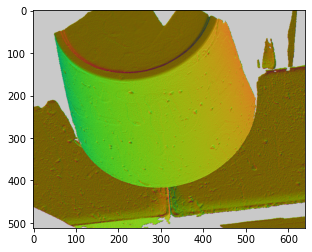

In [188]:
plt.imshow(normals[0].cpu().permute(1,2,0).numpy() * 0.5 + 0.5);

In [189]:
(normals[0].cpu().permute(1,2,0).numpy() * 0.5 + 0.5)[0,0,:]

array([0.7882353, 0.7882353, 0.7882353], dtype=float32)

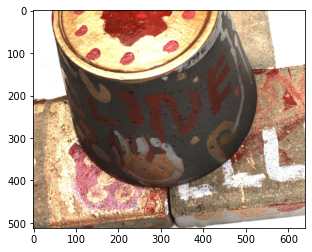

In [190]:
plt.imshow(images[0].cpu().permute(1,2,0).numpy());

#### current way of doing mask

In [194]:
valid_mask = ((normals **2).sum(dim = 1) > 0.8) # Remove invalid pixels of normals

if dataset == 'BlendedMVS' or dataset == 'DTU':
    angle_sharp_mask =  sharp_normal_mask(normals)
    valid_mask = valid_mask & (angle_sharp_mask[0] == 0)   

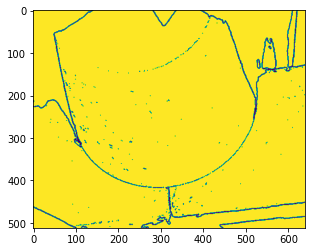

In [195]:
plt.imshow(valid_mask[0].cpu());

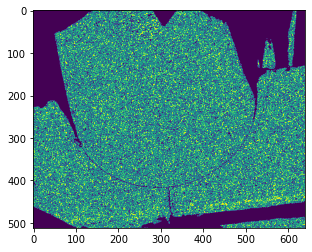

In [25]:
# This just removes non-normalized pixels (soft threshold)
# valid_mask = ((normals **2).sum(dim = 1) > 0.8) # Remove invalid pixels of normals

# however, many of the invalid pixels ARE normalized (e.g. [0,0,0],[128,128,128],[201,201,201])
# this shows a very strict non-normalized threshold 

valid_mask = ((normals **2).sum(dim = 1) > 1)
if dataset == 'BlendedMVS' or dataset == 'DTU':
    angle_sharp_mask =  sharp_normal_mask(normals)
    valid_mask = valid_mask & (angle_sharp_mask[0] == 0)  

plt.imshow(valid_mask[0].cpu());

In [74]:
# this represents the gray
gray = normals[0,:,0,0]
gray

tensor([0.5765, 0.5765, 0.5765])

In [75]:
normals[0].shape

torch.Size([3, 512, 640])

In [76]:
torch.tensor([0.5765, 0.5765, 0.5765]).view(3,1,1).shape

torch.Size([3, 1, 1])

In [77]:
torch.tensor([0.5765, 0.5765, 0.5765]).expand(4, 4, 3).shape

torch.Size([4, 4, 3])

tensor(161071)

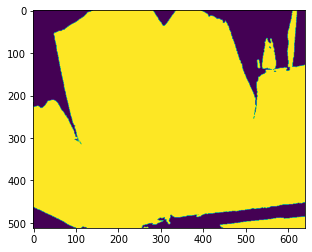

In [78]:
gray2 = torch.tensor([0.5765, 0.5765, 0.5765])
valid_mask = torch.eq(normals[0],gray.view(3,1,1))
tmp = torch.logical_and(valid_mask[0], valid_mask[2])
final = torch.logical_and(tmp, valid_mask[1])
final = ~final

plt.imshow(final.cpu());
valid_mask.sum()

In [79]:
gray == gray2

tensor([False, False, False])

In [80]:
gray

tensor([0.5765, 0.5765, 0.5765])

In [81]:
gray2

tensor([0.5765, 0.5765, 0.5765])

In [82]:
torch.allclose(gray, gray2)

False

In [83]:
print(gray.sum())

tensor(1.7294)


In [84]:
print(gray2.sum())

tensor(1.7295)


### Numerical errors is making this REALLY annoying
## Need to convert to uint8

tensor([201, 201, 201], dtype=torch.uint8)

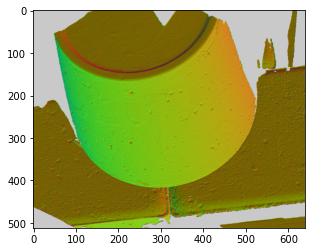

In [92]:
normals_rgb = ((normals[0].cpu() * 0.5 + 0.5)*255).to(torch.uint8)
plt.imshow(normals_rgb.permute(1,2,0).numpy());
normals_rgb[:,0,0]

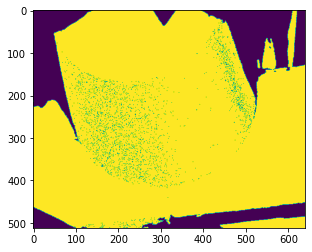

In [104]:
normals_rgb = ((normals[0].cpu() * 0.5 + 0.5)*255).to(torch.uint8)
valid_mask = ~(torch.eq(normals_rgb,201).sum(dim=0) > 0)
plt.imshow(valid_mask.cpu());

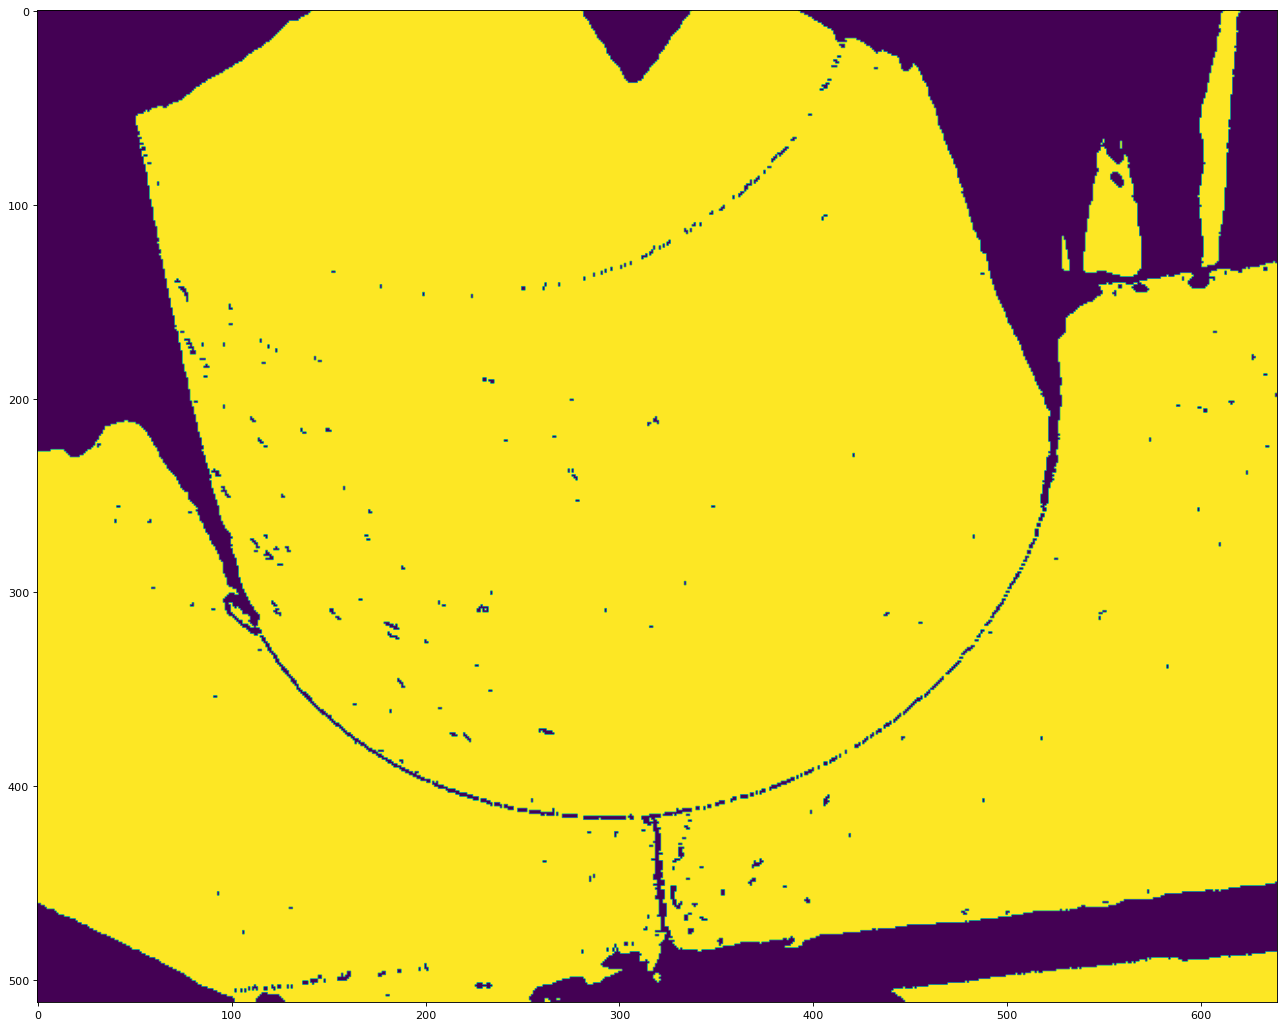

In [118]:
valid_mask = ((normals **2).sum(dim = 1) > 0.8) # Remove invalid pixels of normals
valid_mask = valid_mask & ~(torch.eq(normals_rgb,201).sum(dim=0) > 2)
valid_mask = valid_mask & ~(torch.eq(normals_rgb,0).sum(dim=0) > 2)
valid_mask = valid_mask & ~(torch.eq(normals_rgb,128).sum(dim=0) > 2)

if dataset == 'BlendedMVS' or dataset == 'DTU':
    angle_sharp_mask =  sharp_normal_mask(normals)
    valid_mask = valid_mask & (angle_sharp_mask[0] == 0)
    normals_rgb = ((normals[0].cpu() * 0.5 + 0.5)*255).to(torch.uint8)

    
plt.figure(figsize=(20, 18), dpi=80)
plt.imshow(valid_mask[0].cpu());

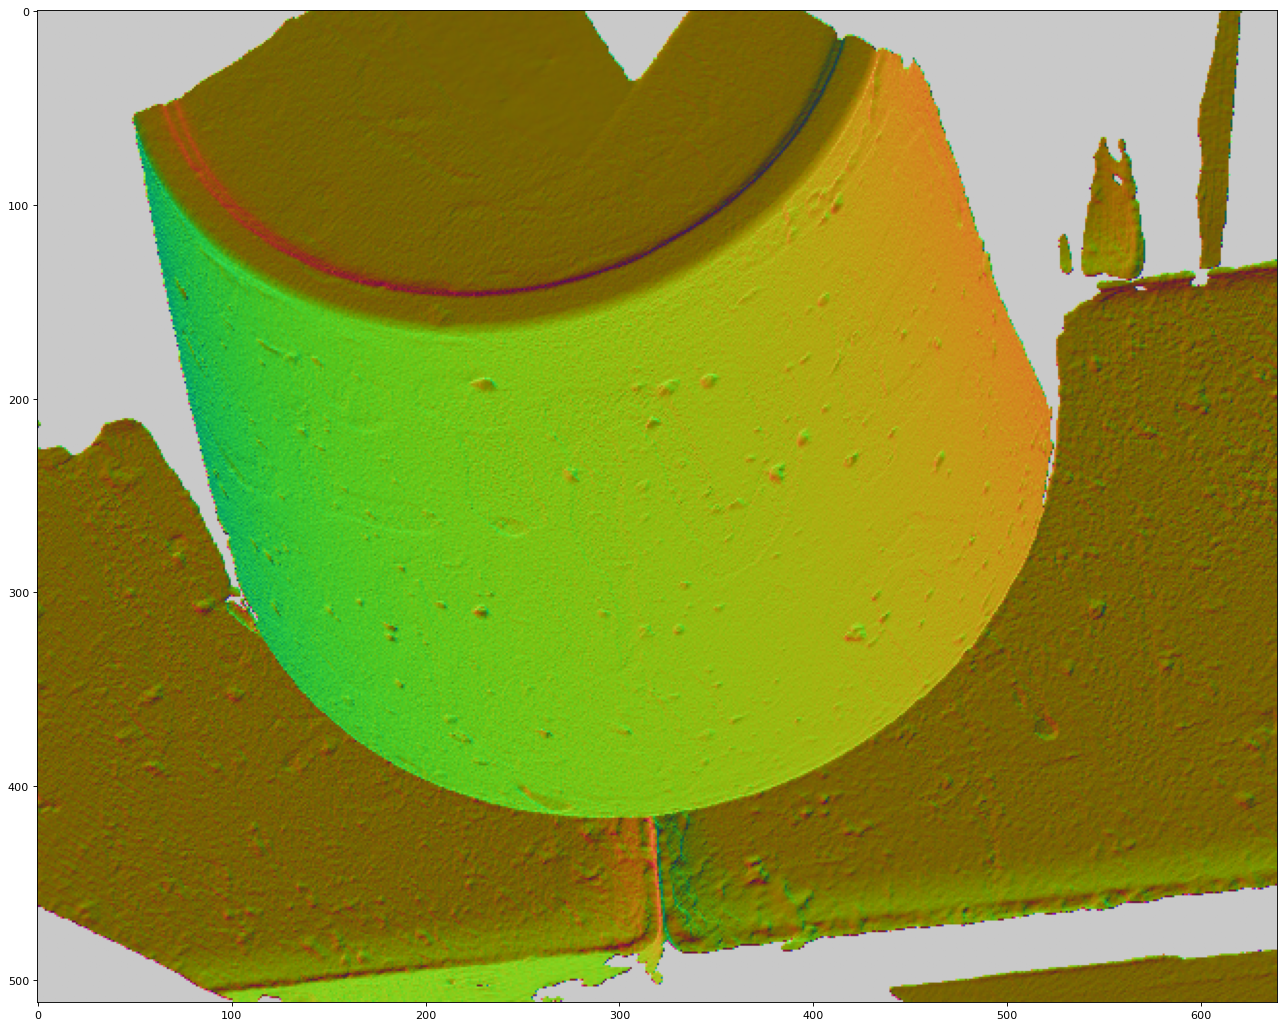

In [116]:
plt.figure(figsize=(20, 18), dpi=80)
plt.imshow(normals[0].cpu().permute(1,2,0).numpy() * 0.5 + 0.5);

# Final

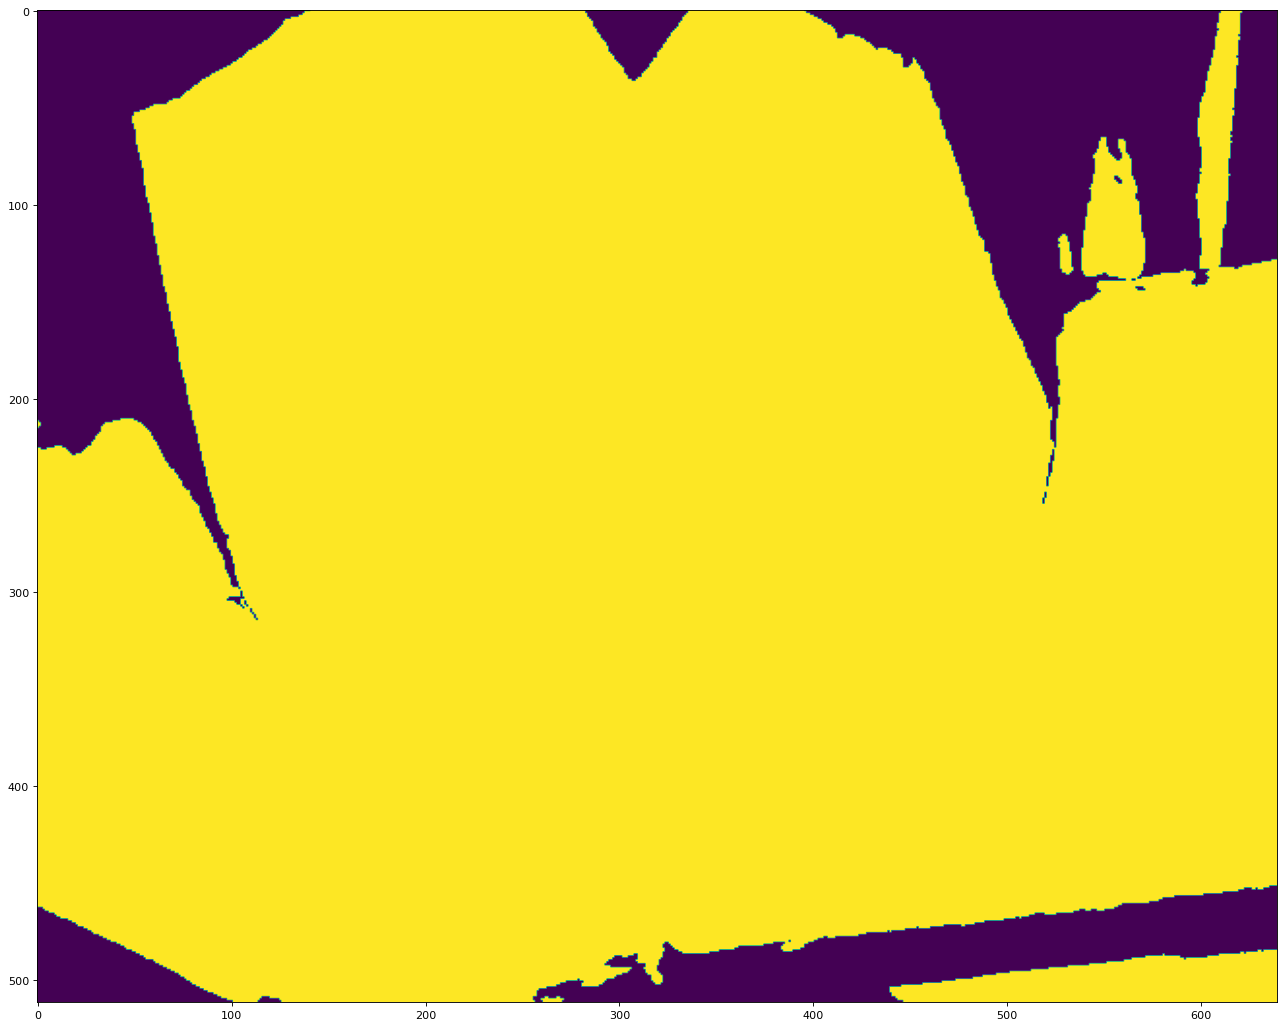

In [157]:
valid_mask = ((normals **2).sum(dim = 1) > 0.8) # Remove invalid pixels of normals 
# #doesn't do anything for this image

if dataset == 'BlendedMVS' or dataset == 'DTU':
    angle_sharp_mask =  sharp_normal_mask(normals)
#     valid_mask = valid_mask & (angle_sharp_mask[0] == 0)
    normals_rgb = ((normals[0] * 0.5 + 0.5)*255).to(torch.uint8)  
if dataset == 'BlendedMVS':
    valid_mask = valid_mask & ~(torch.eq(normals_rgb,0).sum(dim=0) > 2)
    valid_mask = valid_mask & ~(torch.eq(normals_rgb,128).sum(dim=0) > 2)
if dataset == 'DTU':
    valid_mask = valid_mask & ~(torch.eq(normals_rgb,201).sum(dim=0) > 2)  
    
plt.figure(figsize=(20, 18), dpi=80)
plt.imshow(valid_mask[0]);

## Make sure this is the SAME as my mask

In [266]:
# modified from.....
# https://github.com/allenai/grit/blob/main/metrics/normal.py#L115-L124

def ryan(normals):
    # convert to numpy
    numpy_normals = normals[0].permute(1,2,0).cpu().numpy()
    # convert to rgb
    numpy_normals_rgb = normal2rgb(numpy_normals)
    # masks out values of [0,0,0], [128,128,128], or [201,201,201]
    valid_mask_0 = (numpy_normals_rgb != 0).sum(axis=2) != 0
    valid_mask_128 = (numpy_normals_rgb != 128).sum(axis=2) != 0 
    valid_mask_201 = (numpy_normals_rgb != 201).sum(axis=2) != 0
    valid_mask = np.logical_and.reduce((valid_mask_0, valid_mask_128, valid_mask_201))
    return valid_mask

def rgb2normal(rgb):
    n = (rgb-122.5)/122.5
    n /= np.linalg.norm(n, ord=2, axis=2, keepdims=True)
    return n

def normal2rgb(n):
    rgb = (n + 1)/2
    rgb *= 255
    return rgb.astype(np.uint8)

In [253]:
normals.shape

torch.Size([1, 3, 512, 640])

In [254]:
numpy_normals = normals[0].permute(1,2,0).numpy()

In [255]:
numpy_normals.shape

(512, 640, 3)

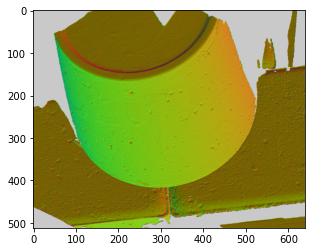

In [256]:
numpy_normals_rgb = normal2rgb(numpy_normals)
plt.imshow(numpy_normals_rgb);

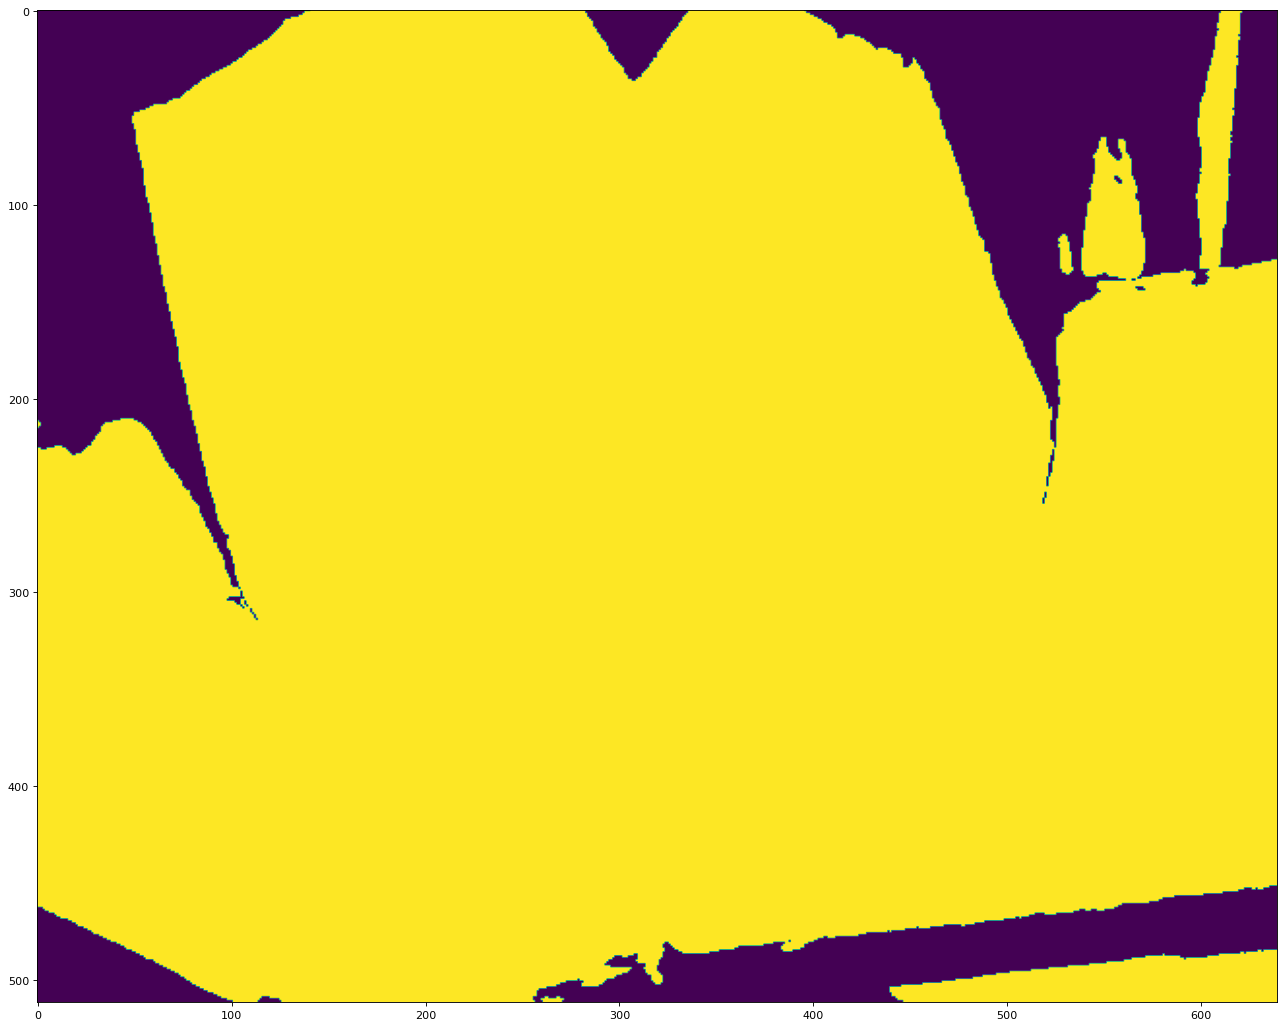

In [269]:
plt.figure(figsize=(20, 18), dpi=80)
plt.imshow(ryan(normals));

## SAME


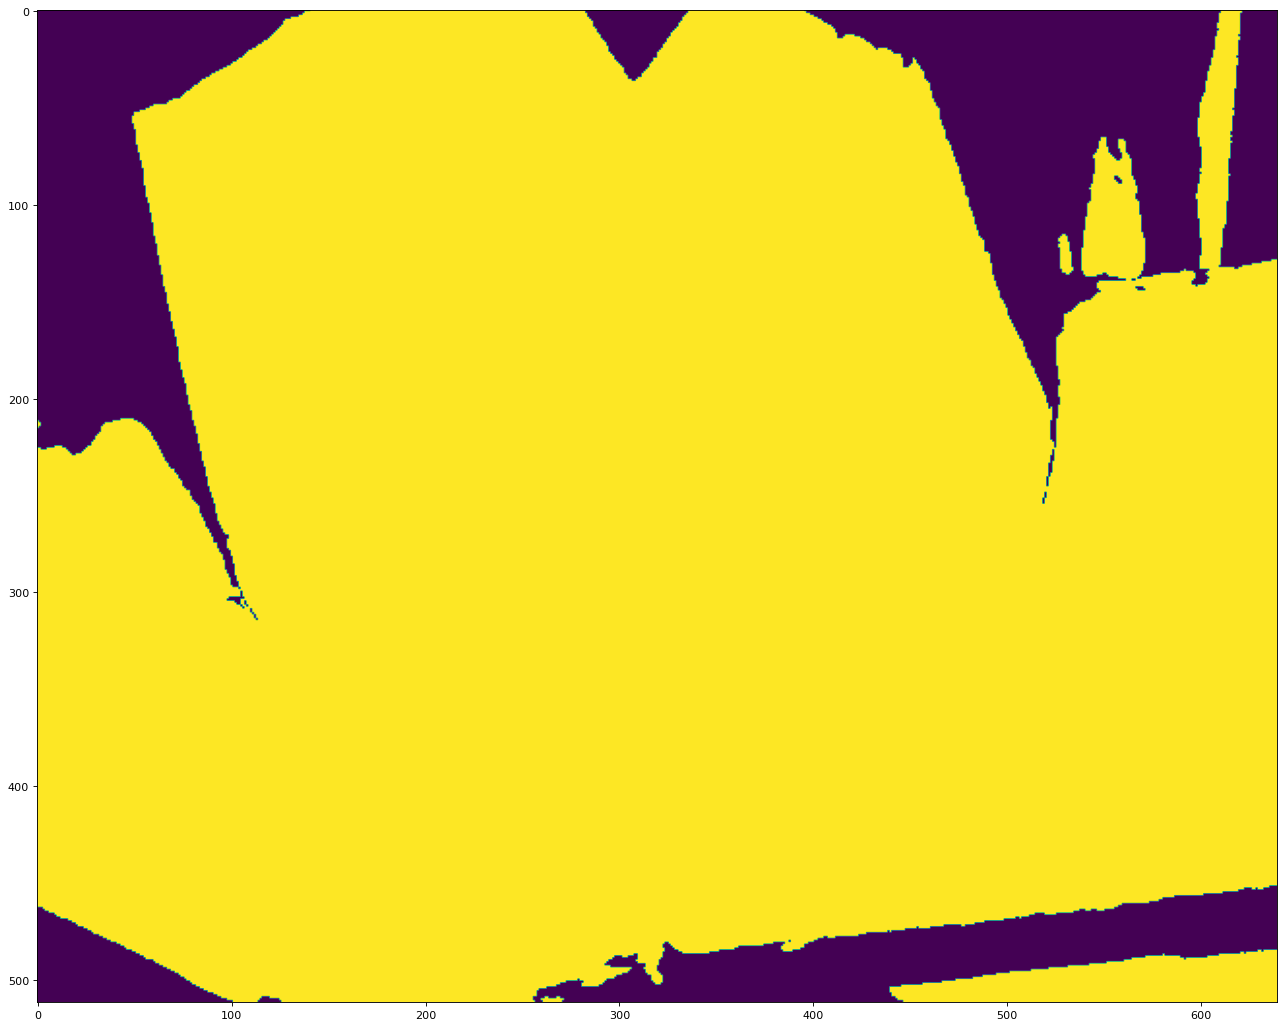

In [268]:
def yuqun(normals):
    normals_rgb = ((normals[0] * 0.5 + 0.5)*255).to(torch.uint8)
    valid_mask = (torch.ne(normals_rgb,0).sum(dim=0) != 0)
    valid_mask &=(torch.ne(normals_rgb,128).sum(dim=0) != 0)
    valid_mask &= (torch.ne(normals_rgb,201).sum(dim=0) != 0)
    valid_mask = valid_mask.unsqueeze(dim=0)
    return valid_mask

valid_mask = yuqun(normals)
plt.figure(figsize=(20, 18), dpi=80)
plt.imshow(valid_mask[0]);

## These masks are now equivalent

In [267]:
(yuqun(normals)[0].cpu().numpy() == ryan(normals)).all()

True